
Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.



Epoch 1/16


198/198 [==============================] - 952s 5s/step - loss: 0.4505 - accuracy: 0.8440 - val_loss: 0.4879 - val_accuracy: 0.8145
Epoch 2/16
198/198 [==============================] - 877s 4s/step - loss: 0.2633 - accuracy: 0.9004 - val_loss: 0.3619 - val_accuracy: 0.8703
Epoch 3/16
198/198 [==============================] - 861s 4s/step - loss: 0.2395 - accuracy: 0.9075 - val_loss: 0.3502 - val_accuracy: 0.8703
Epoch 4/16
198/198 [==============================] - 877s 4s/step - loss: 0.2165 - accuracy: 0.9189 - val_loss: 0.3388 - val_accuracy: 0.8729
Epoch 5/16
198/198 [==============================] - 842s 4s/step - loss: 0.2192 - accuracy: 0.9202 - val_loss: 0.3908 - val_accuracy: 0.8755
Epoch 6/16
198/198 [==============================] - 832s 4s/step - loss: 0.2026 - accuracy: 0.9241 - val_loss: 0.2943 - val_accuracy: 0.8872
Epoch 7/16
198/198 [==============================] -

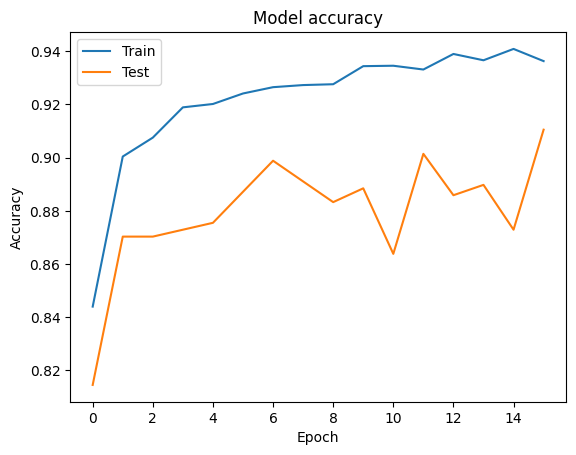

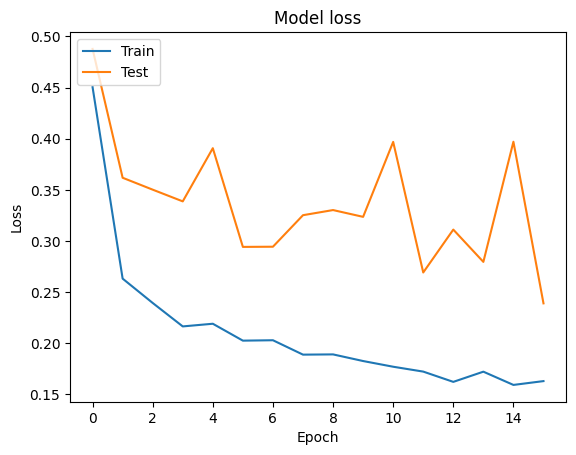

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
from efficientnet.tfkeras import EfficientNetB0
import matplotlib.pyplot as plt

# Define paths and parameters
train_data_dir = 'E:/Chest X-Ray (Pneumonia,Covid19,Tuberculosis)/train'
test_data_dir = 'E:/Chest X-Ray (Pneumonia,Covid19,Tuberculosis)/test'
image_size = (224, 224)
batch_size = 32
num_classes = 4  # Update to the number of classes in your dataset
epochs = 16

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Feature extraction using EfficientNet
efficientnet_base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size[0], image_size[1], 3)
)
efficientnet_base_model.trainable = False

# Feature extraction using ResNet50
resnet_base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size[0], image_size[1], 3)
)
resnet_base_model.trainable = False

# Feature extraction using InceptionV3
inception_base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size[0], image_size[1], 3)
)
inception_base_model.trainable = False

# Input layer
input_layer = tf.keras.Input(shape=(image_size[0], image_size[1], 3))

# Extract features using EfficientNet
efficientnet_features = efficientnet_base_model(input_layer)
efficientnet_features = layers.GlobalAveragePooling2D()(efficientnet_features)

# Extract features using ResNet50
resnet_features = resnet_base_model(input_layer)
resnet_features = layers.GlobalAveragePooling2D()(resnet_features)

# Extract features using InceptionV3
inception_features = inception_base_model(input_layer)
inception_features = layers.GlobalAveragePooling2D()(inception_features)

# Concatenate features
combined_features = layers.concatenate([efficientnet_features, resnet_features, inception_features])

# Build the final classification model
x = layers.Dense(256, activation='relu')(combined_features)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Generate classification report
class_names = list(train_generator.class_indices.keys())
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
